# Generalized Advantage Estimation

## Imports

In [1]:
import gym
gym.logger.set_level(40)

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta
import os
import glob


from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

from utils.hyperparameters import Config
from utils.plot import plot
from utils.wrappers import make_env_a2c_atari
from agents.A2C import Model as A2C

## Hyperparameters

In [2]:
log_dir = "/tmp/gym/"

try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    for f in files:
        os.remove(f)

config = Config()

#a2c control
config.num_agents=16
config.rollout=5
config.USE_GAE=True
config.gae_tau = 0.95

#misc agent variables
config.GAMMA=0.99
config.LR=7e-4
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5

# Number of updates in 10000000 frames
config.MAX_FRAMES=int(1e7 / config.num_agents / config.rollout)

## Rollout Storage

In [3]:
class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, device, USE_GAE=True, gae_tau=0.95):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0
        self.gae = USE_GAE
        self.gae_tau = gae_tau

    def insert(self, current_obs, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        self.value_preds[-1] = next_value
        gae = 0
        for step in reversed(range(self.rewards.size(0))):
            delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
            gae = delta + gamma * self.gae_tau * self.masks[step + 1] * gae
            self.returns[step] = gae + self.value_preds[step]

## Agent

In [4]:
class Model(A2C):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__(static_policy, env, config)

        self.rollouts = RolloutStorage(self.rollout, self.num_agents,
            self.num_feats, self.env.action_space, self.device, config.USE_GAE, config.gae_tau)

## Training Loop

Updates 125000, Num Timesteps 10000080, FPS 2254,
Mean/Median Reward 18.7/19.0, Min/Max Reward 14.0/21.0,
Entropy 1.59870, Value Loss 0.01055, Policy Loss -0.03340


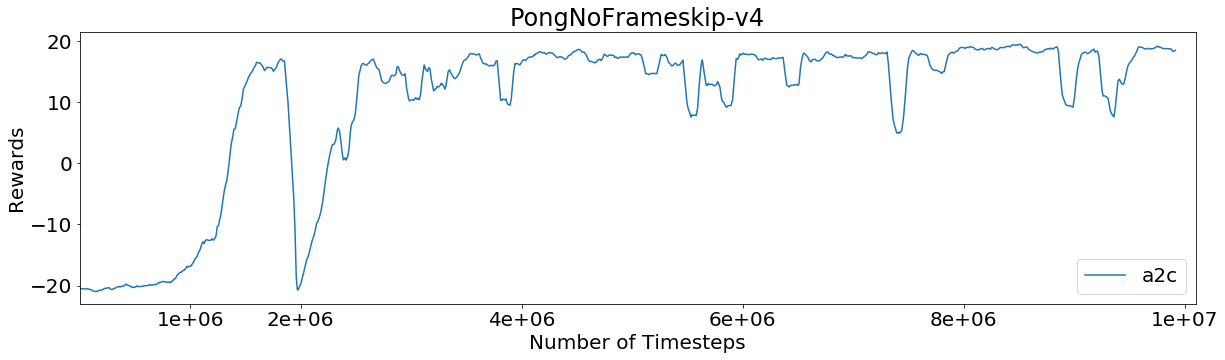

In [5]:
if __name__=='__main__':
    seed = 1

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    torch.set_num_threads(1)

    env_id = "PongNoFrameskip-v4"
    envs = [make_env_a2c_atari(env_id, seed, i, log_dir) for i in range(config.num_agents)]
    envs = SubprocVecEnv(envs) if config.num_agents > 1 else DummyVecEnv(envs)

    obs_shape = envs.observation_space.shape
    obs_shape = (obs_shape[0] * 4, *obs_shape[1:])

    model = Model(env=envs, config=config)

    current_obs = torch.zeros(config.num_agents, *obs_shape,
                    device=config.device, dtype=torch.float)

    def update_current_obs(obs):
        shape_dim0 = envs.observation_space.shape[0]
        obs = torch.from_numpy(obs.astype(np.float32)).to(config.device)
        current_obs[:, :-shape_dim0] = current_obs[:, shape_dim0:]
        current_obs[:, -shape_dim0:] = obs

    obs = envs.reset()
    update_current_obs(obs)

    model.rollouts.observations[0].copy_(current_obs)
    
    episode_rewards = np.zeros(config.num_agents, dtype=np.float)
    final_rewards = np.zeros(config.num_agents, dtype=np.float)

    start=timer()

    print_step = 1
    print_threshold = 10
    
    for frame_idx in range(1, config.MAX_FRAMES+1):
        for step in range(config.rollout):
            with torch.no_grad():
                values, actions, action_log_prob = model.get_action(model.rollouts.observations[step])
            cpu_actions = actions.view(-1).cpu().numpy()
    
            obs, reward, done, _ = envs.step(cpu_actions)

            episode_rewards += reward
            masks = 1. - done.astype(np.float32)
            final_rewards *= masks
            final_rewards += (1. - masks) * episode_rewards
            episode_rewards *= masks

            rewards = torch.from_numpy(reward.astype(np.float32)).view(-1, 1).to(config.device)
            masks = torch.from_numpy(masks).to(config.device).view(-1, 1)

            current_obs *= masks.view(-1, 1, 1, 1)
            update_current_obs(obs)

            model.rollouts.insert(current_obs, actions.view(-1, 1), action_log_prob, values, rewards, masks)
            
        with torch.no_grad():
            next_value = model.get_values(model.rollouts.observations[-1])

        model.rollouts.compute_returns(next_value, config.GAMMA)
            
        value_loss, action_loss, dist_entropy = model.update(model.rollouts)
        
        model.rollouts.after_update()

        if frame_idx % 100 == 0:
            try:
                clear_output()
                end = timer()
                total_num_steps = (frame_idx + 1) * config.num_agents * config.rollout
                print("Updates {}, Num Timesteps {}, FPS {},\nMean/Median Reward {:.1f}/{:.1f}, Min/Max Reward {:.1f}/{:.1f},\nEntropy {:.5f}, Value Loss {:.5f}, Policy Loss {:.5f}".
                format(frame_idx, total_num_steps,
                       int(total_num_steps / (end - start)),
                       np.mean(final_rewards),
                       np.median(final_rewards),
                       np.min(final_rewards),
                       np.max(final_rewards), dist_entropy,
                       value_loss, action_loss))
                plot(log_dir, "PongNoFrameskip-v4", 'a2c', 
                     config.MAX_FRAMES * config.num_agents * config.rollout)
            except IOError:
                pass

    model.save_w()
    envs.close()